# comp551miniproj2 - reddit text classification

In [1]:
# some of the following based on tutorial from https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568

import logging
import pandas as pd
import numpy as np
from numpy import random
from scipy import sparse

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

df = pd.read_csv('reddit-comment-classification-comp-551/reddit_train.csv')
df = df[pd.notnull(df['comments'])]
print(df.head(10))
print(df['comments'].apply(lambda x: len(x.split(' '))).sum())

X_kaggle = pd.read_csv('reddit-comment-classification-comp-551/reddit_test.csv')
X_kaggle = X_kaggle[pd.notnull(X_kaggle['comments'])]
print(X_kaggle.head(10))
print(X_kaggle['comments'].apply(lambda x: len(x.split(' '))).sum())



   id                                           comments       subreddits
0   0  Honestly, Buffalo is the correct answer. I rem...           hockey
1   1  Ah yes way could have been :( remember when he...              nba
2   2  https://youtu.be/6xxbBR8iSZ0?t=40m49s\n\nIf yo...  leagueoflegends
3   3  He wouldn't have been a bad signing if we woul...           soccer
4   4  Easy. You use the piss and dry technique. Let ...            funny
5   5  The joke is on YOU!\n\nI've only seen it twice...            funny
6   6  His role in MI3 is one of the best villians I'...           movies
7   7  Akagi is still Alpha as fuck and Sugawara is s...            anime
8   8  I think that they had each other's detonator. ...           movies
9   9  Right! He was a disruptor tank! Pull the dps o...        Overwatch
2968210
   id                                           comments
0   0  Trout and Bryant have both led the league in s...
1   1  &gt; Just like Estonians have good reasons to ...
2   2  

The classes are balanced, but the text needs cleaning. Here's some cleaning:

In [2]:
import nltk
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

delimiters = re.compile('[/(){}\[\]\|@,;]')
ignored_symbols = re.compile('[^0-9a-z #+_]')
# nltk.download('stopwords')
stopwords = set(stopwords.words('english'))


def clean_text(text):
    """
        text: a string (one comment)
        return: modified string
    """
#     text = BeautifulSoup(text, "lxml").text # HTML decoding # our pipeline does slightly better without this.
    text = text.lower() # lowercase text
    text = delimiters.sub(' ', text) # replace delimiters symbols by space in text
    text = ignored_symbols.sub('', text) # delete symbols which are in ignored_symbols from text
    text = ' '.join(word for word in text.split() if word not in stopwords) # delete stopwords from text
    return text
    
df['comments'] = df['comments'].apply(clean_text)

#COMPETITION SET
X_kaggle['comments'] = X_kaggle['comments'].apply(clean_text)


Now to lemmatize the corpus.  This might not help in the short term, but will be useful to play with. 


In [4]:
from nltk.tokenize import word_tokenize

from nltk.stem import LancasterStemmer, PorterStemmer
#stemmer = LancasterStemmer()
stemmer = PorterStemmer()

def stem_sentence(sen):
    """ stems every word in space separated sentence sen """ 
    token_list = word_tokenize(sen)
    stem_sen = []
    for w in token_list:
        stem_sen.append(stemmer.stem(w))
    return " ".join(stem_sen)

# Download wordnet (could take a little while!), to do lemmatization
# nltk.download('wordnet')
# from nltk.stem import WordNetLemmatizer 
# lemmatizer = WordNetLemmatizer() 

# def lemm_sentence(sen):
#     """ lemmatizes every word in space separated sentence sen """ 
#     token_list = word_tokenize(sen)
#     lemma_sen = []
#     for w in token_list:
#         lemma_sen.append(lemmatizer.lemmatize(w))
#     return " ".join(lemma_sen)


# choose lemm_sentence)() for lemmatization, or stem_sentence() for stemming.
df['comments'] = df['comments'].apply(lambda x: stem_sentence(x))

# print_plot(1234)
print(df.head(10))

#COMPETITION SET
# choose lemm_sentence)() for lemmatization, or stem_sentence() for stemming.
X_kaggle['comments'] = X_kaggle['comments'].apply(lambda x: stem_sentence(x))
X_kaggle = pd.Series(X_kaggle['comments'], index=X_kaggle.index)
# print_plot(1234)

   id                                           comments       subreddits
0   0  honestli buffalo correct answer rememb peopl s...           hockey
1   1  ah ye way could rememb draft thought gon na gr...              nba
2   2  http youtub 6xxbbr8isz0t40m49sif didnt find al...  leagueoflegends
3   3  wouldnt bad sign wouldnt paid 18m euro right p...           soccer
4   4  easi use piss dri techniqu let drop let dri ri...            funny
5   5                              joke youiv seen twice            funny
6   6  role mi3 one best villian ive seen movi genuin...           movies
7   7  akagi still alpha fuck sugawara suffer definit...            anime
8   8  think other deton wouldnt proven joker right b...           movies
9   9  right disruptor tank pull dp frey pick get poi...        Overwatch


We could set the train test split here, but we could also do some more processing

In [17]:
# X_train, X_test, y_train, y_test = train_test_split(df.comments, df.subreddits, test_size=0.3, random_state = 12)

In [5]:
values_array = np.unique(df.subreddits.values)

Defining a function to get **a list of words in the entire corpus of comments** (that is, `tokens`), and also **a list unique words** (that is `types`).

In [19]:
# import itertools

# tokens_list = df['comments'].apply(lambda x: word_tokenize(x)).values

# tokens = np.array(list(itertools.chain.from_iterable(tokens_list)))

# types, type_counts = np.unique(tokens, return_counts=True)

# print("number of tokens",len(tokens))
# print("number of types",len(types))

Some words are more common than others.  We might want to do something with this. But for now it's just useful to have the information.  I'll make an uncommon-word list. We can remove them just like we did the stopwords. *We'll do this later, with scikitlearn's CountVectorizer*.

In [20]:
# common_words = types[type_counts > 20]
# len(common_words)

In [21]:
# def downsize_vocab(text):
#     text = ' '.join(word for word in text.split() if word in common_words) # keep only common words
#     return text
    
# df['comments'] = df['comments'].apply(downsize_vocab)

In [22]:
# tokens_list = df['comments'].apply(lambda x: word_tokenize(x)).values

# tokens = np.array(list(itertools.chain.from_iterable(tokens_list)))

# types, type_counts = np.unique(tokens, return_counts=True)

# print("number of tokens",len(tokens))
# print("number of types",len(types))

Now that it is cleand, set the train test split of the data.

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.comments, df.subreddits, test_size=0.3, random_state = 777)

In [24]:
#from sklearn.feature_extraction.text import TfidfTransformer
#tfidf = TfidfTransformer()
#X_tfidf = tfidf.fit_transform(X_tf)

In [42]:
# X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df.subreddits, test_size=0.3, random_state = 99)

## Running sklearn classifier models

accuracy 0.5773809523809523
                 precision    recall  f1-score   support

      AskReddit       0.27      0.30      0.28      1061
GlobalOffensive       0.67      0.67      0.67      1023
          Music       0.65      0.68      0.67      1029
      Overwatch       0.66      0.73      0.69      1028
          anime       0.60      0.67      0.64      1015
       baseball       0.71      0.65      0.68      1028
         canada       0.43      0.48      0.45      1056
     conspiracy       0.45      0.46      0.45      1104
         europe       0.51      0.51      0.51      1044
          funny       0.25      0.20      0.22      1046
  gameofthrones       0.77      0.75      0.76      1043
         hockey       0.69      0.62      0.66      1065
leagueoflegends       0.77      0.66      0.71      1079
         movies       0.58      0.61      0.60      1024
            nba       0.71      0.66      0.69      1077
            nfl       0.69      0.62      0.65      1052
  

<IPython.core.display.Javascript object>


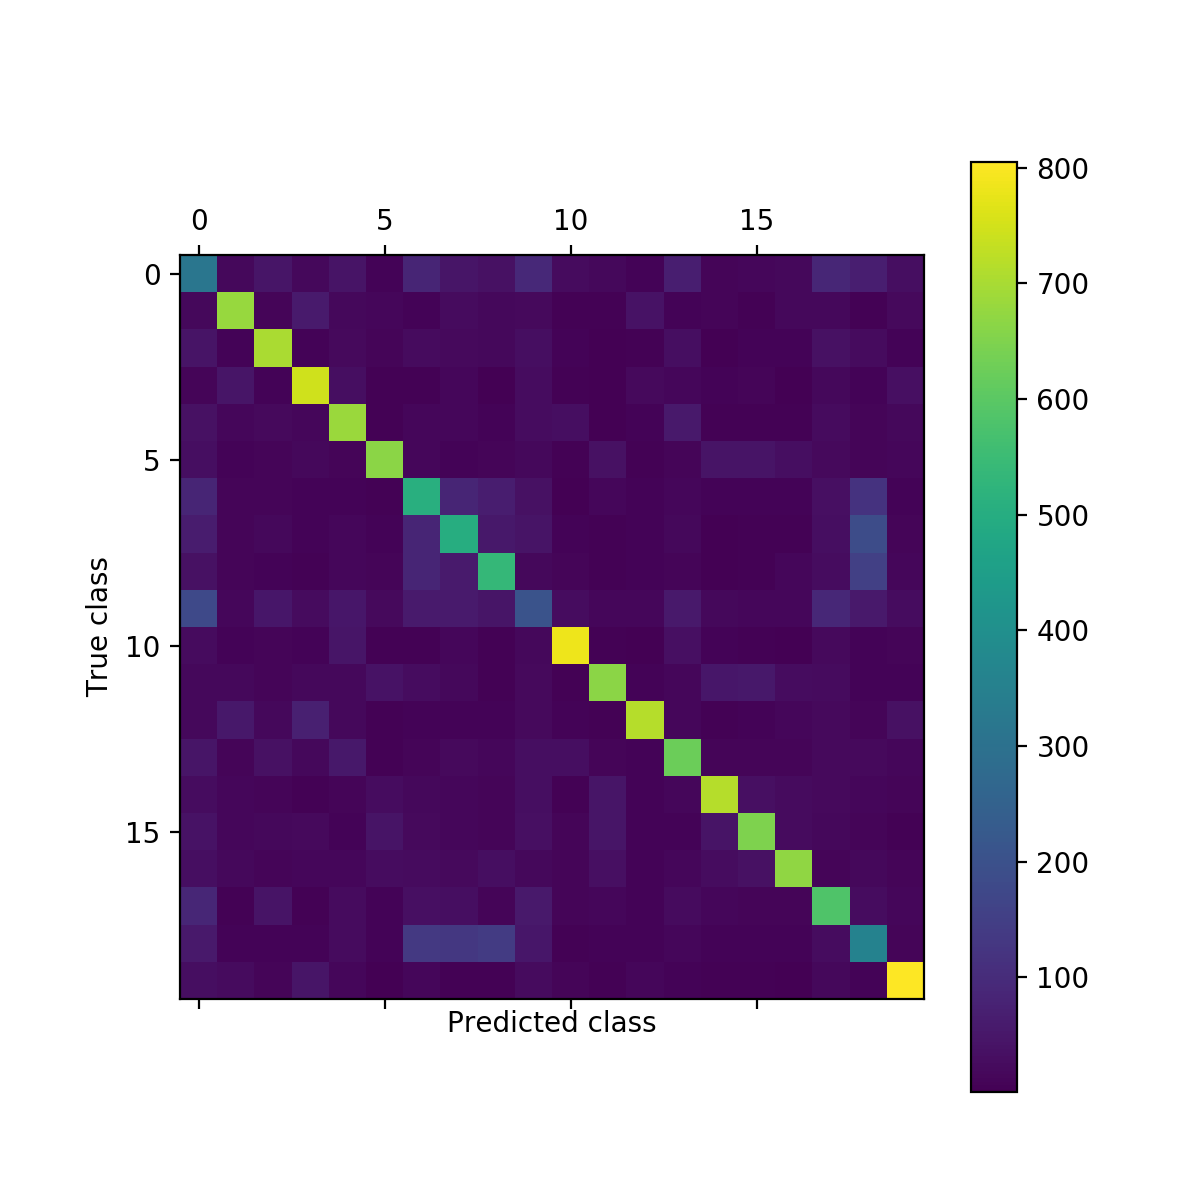

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

from sklearn.naive_bayes import BernoulliNB
bernoulli_nb = Pipeline([
                         ('ct_vect', CountVectorizer(binary=True)),
                         ('tfidf', TfidfTransformer()),
                         ('clf', BernoulliNB(alpha=0.1)),
                        ])

from sklearn.naive_bayes import MultinomialNB
multinomial_nb = Pipeline([
                         ('ct_vect', CountVectorizer(binary=False)),
                         ('tfidf', TfidfTransformer()),
                         ('clf', MultinomialNB(alpha=0.1)),
                        ])

from sklearn.naive_bayes import ComplementNB
complement_nb = Pipeline([
                         ('ct_vect', CountVectorizer(binary=False)),
                         ('tfidf', TfidfTransformer()),
                         ('clf', ComplementNB(alpha=1)),
                        ])

from sklearn.linear_model import SGDClassifier
sgd = Pipeline([
                 ('ct_vect', CountVectorizer(ngram_range=(1,2))),
                 ('tfidf', TfidfTransformer()),
                 ('clf', SGDClassifier(loss='modified_huber', penalty='l2',
                                       alpha=1e-4, random_state=27,
                                       max_iter=5, tol=None)),
                ])

from sklearn.neighbors import KNeighborsClassifier
knn = Pipeline([
                 ('ct_vect', CountVectorizer(ngram_range=(1,1))),
                 ('tfidf', TfidfTransformer()),
                 ('clf', KNeighborsClassifier(n_neighbors=300, weights = 'distance')),
                ])

from sklearn.linear_model import LogisticRegression
logreg = Pipeline([
                 ('ct_vect', CountVectorizer()), # works well with more features (all 75440 ...)
                 ('tfidf', TfidfTransformer()),
                 ('clf', LogisticRegression(penalty='l2',multi_class='ovr',solver='saga')),
                ])


from sklearn.ensemble import RandomForestClassifier
randfrst = Pipeline([
                 ('ct_vect', CountVectorizer(max_features=5000)),
                 ('feature_selection', SelectFromModel(LinearSVC(C=0.1, penalty="l1", dual=False))), # optional
                 ('tfidf', TfidfTransformer()),
                 ('clf', RandomForestClassifier(n_estimators=10)), # more estimators might be good, but slow
                ])

from sklearn.neural_network import MLPClassifier
mlp = Pipeline([
                 ('ct_vect', CountVectorizer(max_features=5000)),
                 ('tfidf', TfidfTransformer()),
                 ('clf', MLPClassifier(alpha=1, max_iter=100)),
                ])

from sklearn.linear_model import PassiveAggressiveClassifier
passaggr = Pipeline([
                 ('ct_vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('clf', PassiveAggressiveClassifier(fit_intercept=True,C=0.1)),
                ])

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import FunctionTransformer
lda =  Pipeline([
                 ('ct_vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('todense', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),
                 ('clf', LinearDiscriminantAnalysis()),
                ])

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda =  Pipeline([
                 ('ct_vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('todense', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),
                 ('clf', QuadraticDiscriminantAnalysis()),
                ])

# now for comparing and majority voting:
from sklearn.ensemble import VotingClassifier
clf1 = LogisticRegression(penalty='l2',multi_class='ovr',solver='saga')#l2, ovr, newton-cg try lbfgs
clf2 = MultinomialNB(alpha=0.27) #0.25
clf3 = ComplementNB(alpha=0.008) #0.01
clf4 = PassiveAggressiveClassifier(fit_intercept=True,C=0.1) # won't work with voting='soft'!
clf5 = SGDClassifier(loss='modified_huber', penalty='l2',alpha=1e-4, random_state=27,max_iter=5, tol=None)
clf6 = KNeighborsClassifier(n_neighbors=300, weights = 'distance')
clf7 = BernoulliNB(alpha=0.01,binarize=0.0)

voting_clf = Pipeline([
    ('ct_vect', CountVectorizer(binary=False,ngram_range=(1,1))),
    ('tfidf', TfidfTransformer()),
    ('clf' , VotingClassifier(estimators=
                              [('logreg', clf1), ('mnb', clf2), ('cnb', clf3)],
                              voting='hard',n_jobs=-1))
])



parameters = {
        #passagr
#         'clf__C':[0.5,0.1,0.01]
        #voting
         'clf__voting': ['hard','soft'],
#         'clf__estimators':[
#             [('logreg', clf1), ('mnb', clf2), ('cnb', clf3)], # best acc after training on whole train set
#             [('sgd', clf5), ('mnb', clf2), ('cnb', clf3)],    # best acc in 3-fold cv, but not best after training on whole train set
#             [('logreg', clf1), ('cnb', clf3),('sgd', clf5)],
#             [('passaggr', clf4), ('cnb', clf3),('sgd', clf5)],
#             [('passaggr', clf4), ('mnb', clf2), ('cnb', clf3)],
#         ]
        #logreg
#         'ct_vect__ngram_range': [(1,1)],
#         'ct_vect__max_features': [1000,5000,74000],
#         'clf__multi_class':['ovr','multinomial'],
#         'clf__solver':['sag','saga'],
        
#       #knn
#         'ct_vect__ngram_range': [(1,1)],
#         'ct_vect__max_features': [5000,74000],
#         'clf__n_neighbors':[3,30],
        
        #bernoulli_nb
#         'ct_vect__ngram_range': [(1,1)],
#         'ct_vect__max_features': [10000],
#         'clf__alpha': [1,1e-2,1e-3],
        
        #sgd
#        'ct_vect__ngram_range': [(1,1),(1,2)],
#         'ct_vect__max_features': [5000,74400],
#         'clf__alpha': [1e-3, 1e-5],
#         'clf__loss': ['modified_huber', 'hinge'],
    }

#               (alpha=0.0001, average=False, class_weight=None,
#               early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
#               l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
#               max_iter=5, n_iter_no_change=5, n_jobs=None, penalty='l2',
#               power_t=0.5, random_state=27, shuffle=True, tol=None,
#               validation_fraction=0.1, verbose=0, warm_start=False

def paramsearch(modelpipeline,parameters):
    '''
    modelpipeline: sklearn.pipeline.Pipeline object 
    does gridsearch on the given pipeline on test split and prints classification report
    '''
    from sklearn.model_selection import GridSearchCV

    # run gridsearch for parameters with 3-fold cross validation
    gridsearch = GridSearchCV(modelpipeline, parameters, cv=3, iid=False, n_jobs=-1)
    gridsearch = gridsearch.fit(X_train, y_train)
    y_pred = gridsearch.predict(X_test)
    #print(gridsearch.best_params_)
    #print(gridsearch.best_score_)
    print('accuracy %s' % accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=values_array))
    confusion_matrix(y_test, y_pred)
    cm=confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(6,6))
    plt.matshow(cm, fignum=1)
    plt.colorbar()
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    return gridsearch

def runmodel(modelpipeline):
    '''
    modelpipeline: sklearn.pipeline.Pipeline object 
    runs the given pipeline on test split and prints classification report
    '''
    modelpipeline.fit(X_train, y_train)
    y_pred = modelpipeline.predict(X_test)
    # print(modelpipeline)
    print('accuracy %.3f' % accuracy_score(y_test, y_pred))
    # print(classification_report(y_test, y_pred,target_names=values_array))
    print(confusion_matrix(y_test, y_pred))
    

gridsearch = paramsearch(voting_clf,parameters)
    
#runmodel(bernoulli_nb)


In [14]:
import time

models = [
    complement_nb,
    multinomial_nb,
    sgd,
    logreg,
    passaggr,
    bernoulli_nb,
    knn
    # randfrst, #only gets 37
]

for model in models:
    start_time = time.time()
    runmodel(model)
    print("took %.3f seconds for %s" % ((time.time() - start_time), model['clf']))

accuracy 0.566
took 1.944 seconds for ComplementNB(alpha=1, class_prior=None, fit_prior=True, norm=False)
accuracy 0.558
took 1.988 seconds for MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)
accuracy 0.552
took 8.945 seconds for SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=5, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=27, shuffle=True, tol=None,
              validation_fraction=0.1, verbose=0, warm_start=False)
accuracy 0.540
took 12.768 seconds for LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
      

In [40]:
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.tree import DecisionTreeClassifier
# adaboost = Pipeline([
#                  ('ct_vect', CountVectorizer()),
#                  ('tfidf', TfidfTransformer()),
#                  ('clf', AdaBoostClassifier(
#                     ComplementNB(alpha=1),
#                     n_estimators=200,
#                     learning_rate=1))
#                 ]) ## currently getting accuracy 0.44776

# adaparameters = {
# #         'ct_vect__ngram_range': [(1,1),(1,2)],
# #         'ct_vect__max_features': [5000,7000],
# #         'clf__base_estimator__alpha': [1, 0.1, 1e-3],
# #         'clf__learning_rate': [0.001,0.1,1],
#     }
# adagrid = paramsearch(adaboost,adaparameters)


In [52]:
#MAKE PREDICTIONS FOR THE HELDOUT COMPETITION SET
y_kaggle = gridsearch.predict(X_kaggle)
y_kaggle

array(['baseball', 'europe', 'anime', ..., 'GlobalOffensive',
       'gameofthrones', 'wow'], dtype=object)

In [53]:

y_kaggle = pd.Series(y_kaggle, index=X_kaggle.index)
y_kaggle = pd.DataFrame(y_kaggle)
y_kaggle['Id_'] = y_kaggle.index
y_kaggle.insert(loc = 0, column = "Id", value = y_kaggle['Id_'])
y_kaggle = y_kaggle.drop(columns=['Id_'])
y_kaggle = y_kaggle.rename(columns={0: "Category"})
y_kaggle

,Id,Category
0,0,baseball
1,1,europe
2,2,anime
3,3,worldnews
4,4,trees
...,...,...
29995,29995,movies
29996,29996,Music
29997,29997,GlobalOffensive
29998,29998,gameofthrones


In [54]:
y_kaggle.to_csv("predictions577_582.csv", index=False, sep = ',') 

## Our own NB

In [93]:
def fit_naive_bayes(observations, y, num_features,smoothing):

    #Initialize marginal probability for each class
    count_class = np.array(20*[[0]])
    marg_prob = np.array(20*[[1]]) #Laplace smoothing, starting counts with 1

    #Initialize matrix of probabilities of observed features given k
    cond_prob_matrix = np.ones((20,num_features)) * smoothing

    
    #compute marginal probability of each class
    total_comments = y.shape[0]
    for j in range(total_comments):
        count_class[y[j]] += 1
    
    #Marginal probability for each class
    marg_prob = np.true_divide(count_class, total_comments)
    
    observ = observations.nonzero()
    j = 0 #counter of comments
    prev_comment_no = observ[0][0] #counter to see if next comment
    for i in range(observations.shape[0]):
        
        feature_no = observ[1][i]
        comment_no = observ[0][i]
        
        if prev_comment_no != comment_no:
            j += comment_no - prev_comment_no
            prev_comment_no = comment_no
            
        comment_class = y[j]
        cond_prob_matrix[comment_class][feature_no] += 1


    #divide each row of cond_prob_matrix by the count of comments per class
    for i in range(20):
        cond_prob_matrix[i] = np.true_divide(cond_prob_matrix[i], count_class[i])


    cond_prob_matrix = cond_prob_matrix.transpose()
    marg_prob = np.log(marg_prob)

    #marg_prob is a vector of 20, cond_prob_matrix a matrix #features rows by 20
    return marg_prob, cond_prob_matrix 

In [61]:
classes = {
        "anime": 1,
        "AskReddit": 2,
        "baseball": 3,
        "canada": 4, 
        "conspiracy": 5, 
        "europe": 6, 
        "funny": 7, 
        "gameofthrones": 8, 
        "GlobalOffensive": 9,
        "hockey" :10, 
        "leagueoflegends": 11, 
        "movies": 12, 
        "Music": 13, 
        "nba":14, 
        "nfl":15, 
        "Overwatch":16, 
        "soccer":17, 
        "trees":18, 
        "worldnews":19, 
        "wow":0
    }

y_traindf = pd.DataFrame(y_train)
y_traindf['subreddits']= y_traindf['subreddits'].map(classes)
y_train_array = np.array(y_traindf['subreddits'])

In [210]:
cv = CountVectorizer(max_features=7000,binary=True)
X_train_tf = cv.fit_transform(X_train)
X_test_tf = cv.transform(X_test)

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=7000, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)


In [165]:
import time
start_time = time.time()

# from naive_bayes import fit_naive_bayes
prior, conditional = fit_naive_bayes(X_train_tf, y_train_array, X_train_tf.shape[1],0.1)

print("Took %s seconds." % (time.time() - start_time))

Took 0.3103196620941162 seconds.


In [147]:
ID_list = X_test.index.tolist()

In [205]:
from scipy import sparse
def predict_naive_bayes(id_list, observations, marg_prob, cond_prob_matrix):

    #log of inverse conditional probability matrix
    inv_cond_prob_matrix = np.ones((cond_prob_matrix.shape[0], cond_prob_matrix.shape[1]))
    inv_cond_prob_matrix = inv_cond_prob_matrix - cond_prob_matrix
    inv_cond_prob_matrix = sparse.csr_matrix(np.log(inv_cond_prob_matrix))

    #log of conditional probability matrix
    cond_prob_matrix = sparse.csr_matrix(np.log(cond_prob_matrix))
    
    # 0s become 1s, 1s become 0s
    sparse_ones = sparse.csr_matrix(np.ones((observations.shape[0], observations.shape[1])))
    complement_obs = sparse_ones - observations
    
    
    prob_per_class = observations.dot(cond_prob_matrix) + complement_obs.dot(inv_cond_prob_matrix)
    
    y = []
    for i in range(observations.shape[0]):
        prob_per_class[i] += marg_prob.transpose()
        y.append(np.argmax(prob_per_class[i]))
        
    id_list = np.array(id_list).transpose()

    matrix = np.stack((id_list, y)).transpose()
    df_pred = pd.DataFrame(matrix)

    return df_pred

In [204]:
predictions = predict_naive_bayes(ID_list, X_test_tf, prior, conditional)

In [206]:
predictions

,0,1
0,12045,13
1,5239,2
2,36260,8
3,33645,16
4,51680,13
...,...,...
20995,55928,15
20996,17000,0
20997,68828,19
20998,42940,19


In [207]:
y_testdf = pd.DataFrame(y_test)
y_testdf['subreddits']= y_testdf['subreddits'].map(classes)
y_test_array = np.array(y_testdf['subreddits'])

In [208]:
def accuracy(df_pred, df_true_y):

    pred = np.array(df_pred[1])
    true_y = np.array(df_true_y['subreddits'])

    count = 0
    total = len(true_y)
    for i in range(total):
        if pred[i] == true_y[i]:
            count +=1
            
    return float(count)/total

In [209]:
print(accuracy(predictions, y_testdf))
print(classification_report(y_testdf['subreddits'], predictions[1],target_names=values_array))

0.2917142857142857
                 precision    recall  f1-score   support

      AskReddit       0.27      0.63      0.38      1063
GlobalOffensive       0.38      0.19      0.25      1056
          Music       0.14      0.13      0.14      1003
      Overwatch       0.52      0.09      0.16      1060
          anime       0.20      0.40      0.26      1030
       baseball       0.26      0.13      0.18      1047
         canada       0.26      0.37      0.30      1039
     conspiracy       0.16      0.06      0.09      1084
         europe       0.47      0.55      0.51      1083
          funny       0.53      0.14      0.22      1030
  gameofthrones       0.35      0.31      0.33      1059
         hockey       0.43      0.21      0.28      1043
leagueoflegends       0.31      0.29      0.30      1051
         movies       0.24      0.62      0.34      1050
            nba       0.51      0.19      0.28      1025
            nfl       0.32      0.41      0.36      1055
         so

Here is another implementation of Bernoulli, this one from an online tutorial.

In [215]:
class AnotherBernoulliNB(object):
    ''' based on https://kenzotakahashi.github.io/naive-bayes-from-scratch-in-python.html '''
    def __init__(self, alpha = 1.0):
        self.alpha = alpha

    def fit(self, X, y):
        count_sample = X.shape[0]
        separated = [[x for x, t in zip(X, y) if t == c] for c in np.unique(y)]
        self.class_log_prior_ = [np.log(len(i) / count_sample) for i in separated]
        count = np.array([np.array(i).sum(axis=0) for i in separated]) + self.alpha
        smoothing = 2 * self.alpha
        n_doc = np.array([len(i) + smoothing for i in separated])
        self.feature_prob_ = count / n_doc[np.newaxis].T
        return self

    def predict_log_proba(self, X):
        return [(np.log(self.feature_prob_) * x + \
                 np.log(1 - self.feature_prob_) * np.abs(x - 1)
                ).sum(axis=1) + self.class_log_prior_ for x in X]

    def predict(self, X):
        return np.argmax(self.predict_log_proba(X), axis=1)

In [216]:
nb = BernoulliNB(alpha=0.1)
nb.fit(X_train_tf,y_train)

BernoulliNB(alpha=0.1, binarize=0.0, class_prior=None, fit_prior=True)

In [217]:
newpredictions = nb.predict(X_test_tf)

In [218]:
prediction_df = pd.DataFrame(y_test)
prediction_df['subreddits'] = pd.DataFrame(newpredictions)[0].values
prediction_df

,subreddits
12045,baseball
5239,AskReddit
36260,AskReddit
33645,AskReddit
51680,funny
...,...
55928,hockey
17000,wow
68828,europe
42940,soccer


In [219]:
print('accuracy %s' % accuracy_score(y_test, prediction_df))
print(classification_report(y_testdf['subreddits'], predictions[1],target_names=values_array))

accuracy 0.48533333333333334
                 precision    recall  f1-score   support

      AskReddit       0.27      0.63      0.38      1063
GlobalOffensive       0.38      0.19      0.25      1056
          Music       0.14      0.13      0.14      1003
      Overwatch       0.52      0.09      0.16      1060
          anime       0.20      0.40      0.26      1030
       baseball       0.26      0.13      0.18      1047
         canada       0.26      0.37      0.30      1039
     conspiracy       0.16      0.06      0.09      1084
         europe       0.47      0.55      0.51      1083
          funny       0.53      0.14      0.22      1030
  gameofthrones       0.35      0.31      0.33      1059
         hockey       0.43      0.21      0.28      1043
leagueoflegends       0.31      0.29      0.30      1051
         movies       0.24      0.62      0.34      1050
            nba       0.51      0.19      0.28      1025
            nfl       0.32      0.41      0.36      1055
 